In [1]:
import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
import mdn
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 44100
overlap = 2756

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio(fld, data, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    target = []
    for i, sample in f_df.iterrows():
        if debug: print("File Processing", end="", flush=True)
        y, sr = librosa.load(audio_dir + sample['filename'], sr=SR, mono=True)
        len_second = 5.0
        if debug: print(".", end="", flush=True)
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        if debug: print(".", end="", flush=True)
        items.append(y)
        target.append(sample.target)
        if debug: print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

def load_all_audio(data):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        y, sr = librosa.load(audio_dir + sample['filename'], sr=SR, mono=True)
        len_second = 5.0
        y = y[:int(sr*len_second)]
        y = y[np.newaxis, :]
        items.append(y)
        target.append(sample.target)
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.array(items), np.array(target)

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    target = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [10]:
c_data, targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.861361503601074
(2166, 1, 44100)


# MFCC Visualizer

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
    result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

Instructions for updating:
Colocations handled automatically by placer.
________________________________________________________________________________
Layer (type)              Output Shape              Param #     
static_stft (Spectrogram) (None, 513, 173, 1)       1050624     
________________________________________________________________________________
mel_bank (Filterbank)     (None, 100, 173, 1)       51300       
Total params: 1,101,924
Trainable params: 0
Non-trainable params: 1,101,924
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 6s 3s/step - loss: 1.8647
(1, 44100)


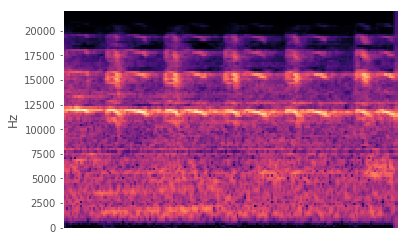

(2166, 173, 100)


In [12]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Spectrogram(n_dft=1024, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=True, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))
model.add(Filterbank(n_fbs=100, trainable_fb=False, sr=SR, init='mel', fmin=0, fmax=SR//2, bins_per_octave=12,
                    name='mel_bank'))
check_model(model)
# for src in c_data:
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])

In [13]:
# Divide audio samples into dilated spectral buffers
def make_dilated_spectral_frames(spectrogram,
                                 num_frames, 
                                 dilation_factor):
    dilated_frames = np.zeros((len(spectrogram), 
                              num_frames, 
                              len(spectrogram[0])))

    for i in range(len(spectrogram)):
        for j in range(num_frames):
            dilation = np.power(dilation_factor, j)

            if i - dilation < 0:
                dilated_frames[i][j] = spectrogram[0]
            else:
                dilated_frames[i][j] = spectrogram[i - dilation]

    return dilated_frames

In [14]:
frames = []
for frame in mfccs:
    frames.append(make_dilated_spectral_frames(frame, 8, 2))

In [15]:
frames = np.vstack(frames)
print(frames.shape)

(374718, 8, 100)


In [16]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        frames, frames, test_size=0.20, random_state=42)

# Dimension Sanity Check

In [17]:
print("Frames: " + str(train_X.shape))
print("Target: " + str(train_y.shape))

Frames: (299774, 8, 100)
Target: (299774, 8, 100)


## Autoencoder

In [18]:
from keras.models import Model
from keras.layers import InputLayer, RepeatVector, Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, Input

def build_pca_autoencoder(img_shape,code_size=32, optimizer_type='adam', loss_type='mse'):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential(name='encoder')
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())                  #flatten image to vector
    encoder.add(Dense(code_size*8, activation='relu'))
    encoder.add(Dense(code_size*4, activation='tanh'))
    encoder.add(Dense(code_size*2, activation='tanh'))
    encoder.add(Dense(code_size))
    encoder.add(Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential(name='decoder')
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(code_size*2, activation='tanh'))
    decoder.add(Dense(code_size*4, activation='tanh'))
    decoder.add(Dense(code_size*8, activation='relu'))
    decoder.add(Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(Reshape(img_shape))         #un-flatten
    
    decoder.compile(optimizer=optimizer_type,
                        loss = loss_type,
                        metrics=['acc'])
    
    inp = Input(img_shape)
    code = encoder(inp)
    reconstruction = decoder(code)
    
    autoencoder = Model(inp, reconstruction)
    autoencoder.compile(optimizer_type, loss_type, metrics=['acc'])
    
    autoencoder.summary()
    
    return autoencoder

def build_deep_conv_autoencoder(code_size, img_shape=(44, 44, 3)):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Conv2D(32, kernel_size=(3, 3),strides=1, padding='same', activation='elu'))
    encoder.add(MaxPool2D(pool_size=(2, 2)))
    encoder.add(Conv2D(64, kernel_size=(3, 3),strides=1, padding='same', activation='elu'))
    encoder.add(MaxPool2D(pool_size=(2, 2)))
    encoder.add(Conv2D(128, kernel_size=(3, 3),strides=1, padding='same', activation='elu'))
    encoder.add(MaxPool2D(pool_size=(2, 2)))
    encoder.add(Conv2D(256, kernel_size=(3, 3),strides=1, padding='same', activation='elu'))
    encoder.add(MaxPool2D(pool_size=(2, 2)))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))
    

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(1024))
    decoder.add(Reshape((2, 2, 256)))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='valid'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='valid'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    return encoder, decoder

In [19]:
from keras.models import model_from_json
try:
    print("Loading Previously Trained Model")
    json_file = open('autoencoder_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    auto = model_from_json(loaded_model_json)
    auto.load_weights('autoencoder_weights.hd5')
    auto.compile(optimizer='adam', loss='mse')
    auto.summary()
except:
    print("Couldn't find model, training new one")
    auto = build_pca_autoencoder(train_X[0].shape,code_size=32)
    auto.fit(x=train_X, y=train_y, epochs=20, verbose=1)
    model_json = auto.to_json()
    with open('autoencoder_model.json', 'w') as json_file:
        json_file.write(model_json)
    auto.save_weights('autoencoder_weights.hd5')

Loading Previously Trained Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 8, 100)            0         
_________________________________________________________________
encoder (Sequential)         (None, 32)                249344    
_________________________________________________________________
decoder (Sequential)         (None, 8, 100)            249056    
Total params: 498,400
Trainable params: 498,400
Non-trainable params: 0
_________________________________________________________________


In [20]:
result = auto.predict(test_X, verbose=1)
print(result.shape)

74944/74944 [==============================] - 8s 108us/step
(74944, 8, 100)


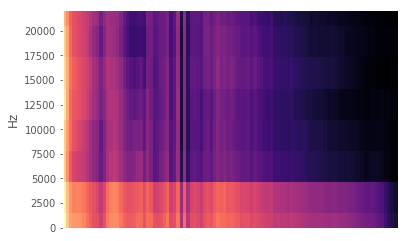

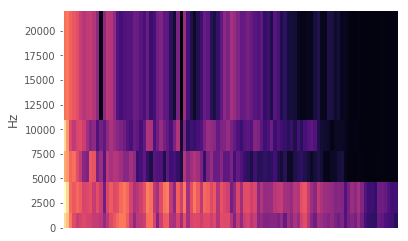

In [21]:
display.specshow(result[7400], y_axis='linear', sr=SR)
plt.show()
display.specshow(test_X[7400], y_axis='linear', sr=SR)
plt.show()

# Encode

In [22]:
enc = keras.models.Sequential(name='encoder')
enc.add(InputLayer((8,100)))
enc.add(auto.get_layer('encoder'))
dta = enc.predict(frames, verbose=1)
print(dta.shape)

374718/374718 [==============================] - 29s 77us/step
(374718, 32)


In [23]:
print(n_targets.shape)

(374718,)


In [24]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        dta, n_targets, test_size=0.20, random_state=42)

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animal vs interacting objects)

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

dropout = 0.25

epochs = 20
batch = 128

latent_dim = 32

src = np.random.random((1, blocksize))

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
Train on 254807 samples, validate on 44967 samples
Epoch 1/20
254807/254807 [==============================] - 18s 72us/step - loss: 0.5194 - acc: 0.7291 - mean_absolute_error: 0.3579 - val_loss: 0.4289 - val_acc: 0.8009 - val_mean_absolute_error: 0.3029
Epoch 2/20
254807

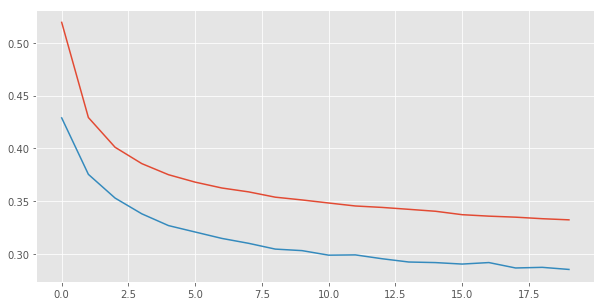

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.8712105038428694
Confusion matrix, without normalization
[[21845  5881]
 [ 3771 43447]]


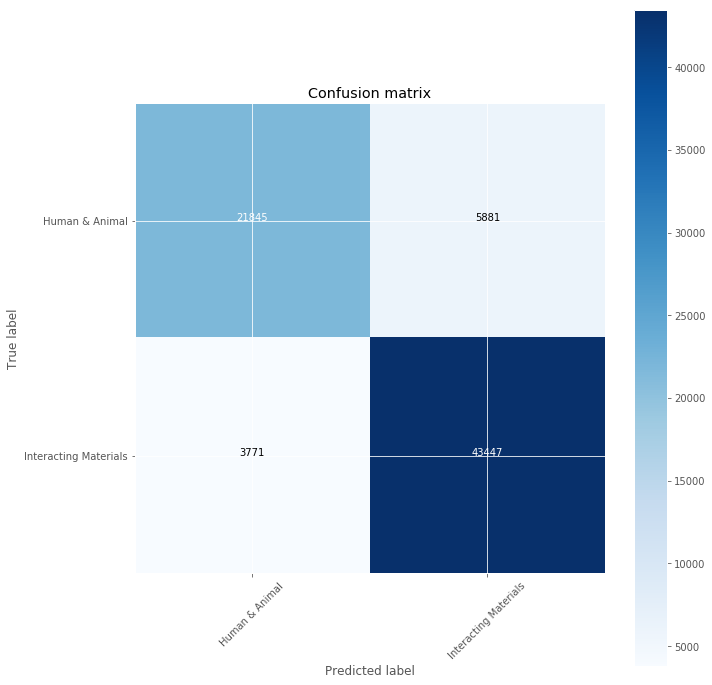

In [28]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [29]:
X2, y2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 2.830677032470703
	Processing Time: 2.842228889465332
	Processing Time: 2.7186241149902344
	Processing Time: 2.7709248065948486


In [30]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(8750, 1, 44100)


In [31]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(8750,)


In [32]:
testing_mfccs = evaluate_model(model, X)
print(testing_mfccs.shape)
test_frames = []
for frame in testing_mfccs:
    test_frames.append(make_dilated_spectral_frames(frame, 8, 2))
test_frames = np.vstack(test_frames)
print(test_frames.shape)
test_dta = enc.predict(test_frames ,verbose=1)
print(test_dta.shape)

(8750, 173, 100)
(8750, 173, 100)
(1513750, 8, 100)
1513750/1513750 [==============================] - 122s 80us/step
(1513750, 32)


In [33]:
testing_n_targets = np.repeat(y, testing_mfccs.shape[1])
print(testing_n_targets.shape)

(1513750,)


1513750/1513750 [==============================] - 20s 13us/step
0.6908095788604459
Confusion matrix, without normalization
[[308072 254351]
 [213686 737641]]


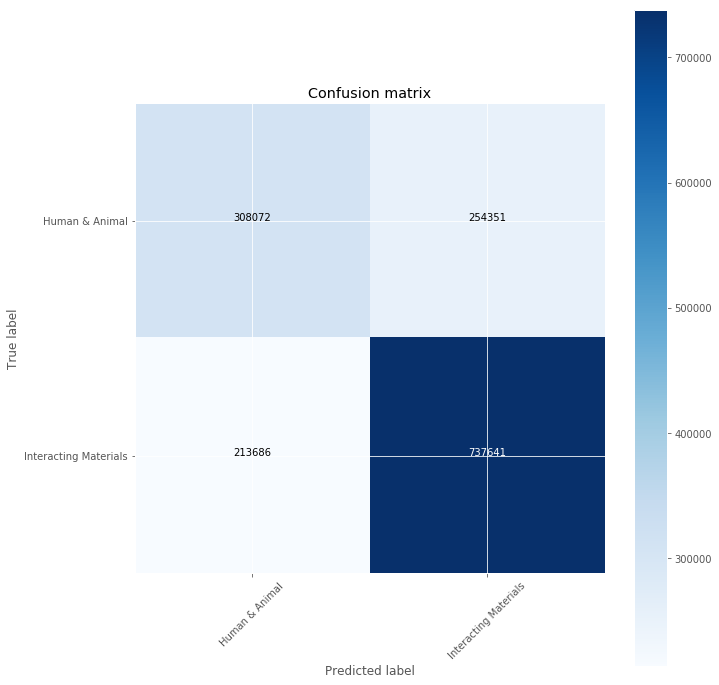

In [34]:
pred = clas.predict(test_dta, verbose=1)
print(metrics.accuracy_score(testing_n_targets, pred))
cm = metrics.confusion_matrix(testing_n_targets, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Testing Accuracy of Single File

In [37]:
total_pred = []
for i in range(0, X.shape[0]):
    x_file = X[i]
    y_file = y[i]
#     print(x_file.shape)
    file_mfccs = evaluate_model(model, np.expand_dims(x_file, axis=0))
#     print(file_mfccs.shape)
    file_frames = []
    for frame in file_mfccs:
        file_frames.append(make_dilated_spectral_frames(frame, 8, 2))
    file_frames = np.vstack(file_frames)
#     print(file_frames.shape)
    test_dta = enc.predict(file_frames ,verbose=0)
#     print(test_dta.shape)
    pred = clas.predict(test_dta, verbose=0)[:,0]
    total_pred.append(np.bincount(pred).argmax())

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 173, 100)
(1, 17

0.7291428571428571
Confusion matrix, without normalization
[[1327 1924]
 [ 446 5053]]


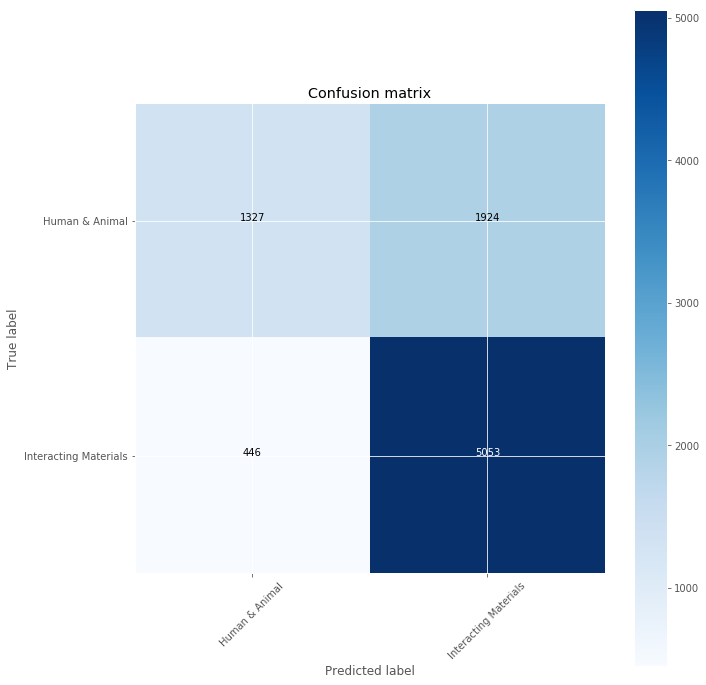

In [38]:
print(metrics.accuracy_score(y, total_pred))
cm = metrics.confusion_matrix(y, total_pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

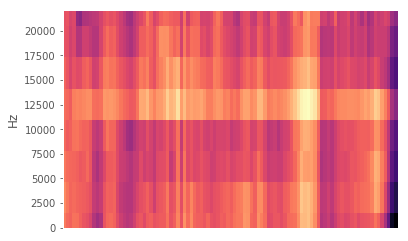

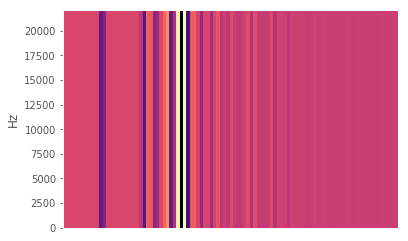

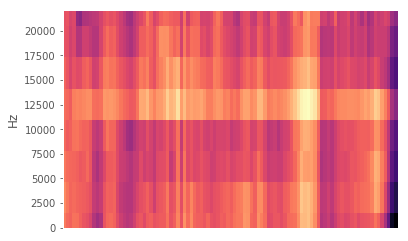

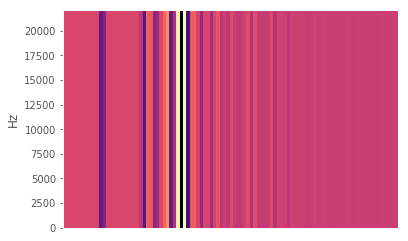

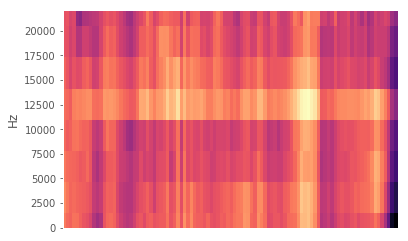

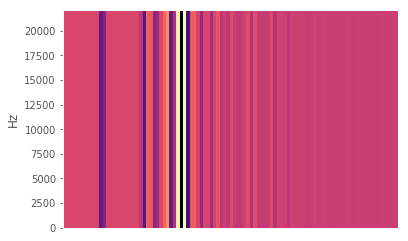

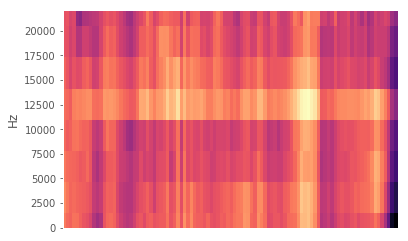

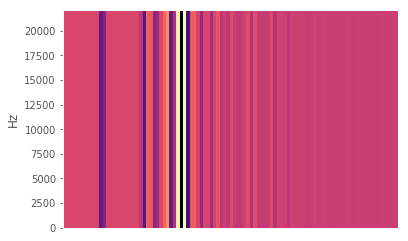

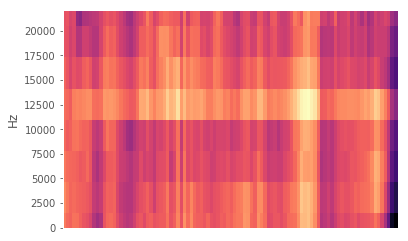

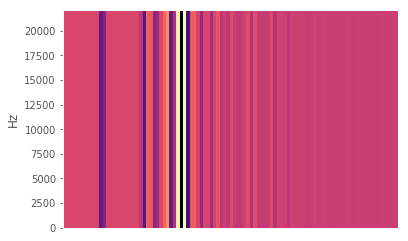

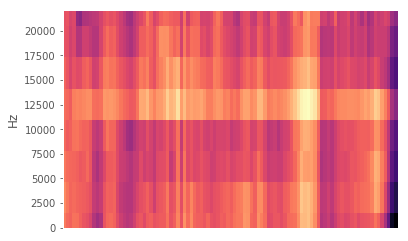

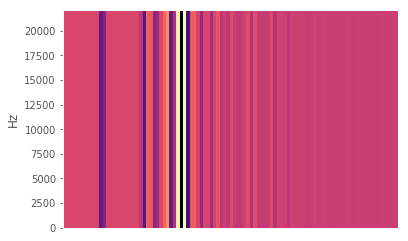

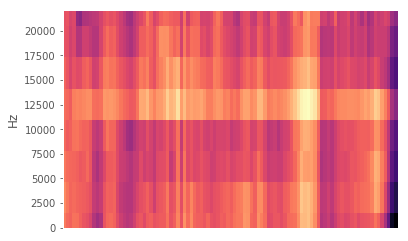

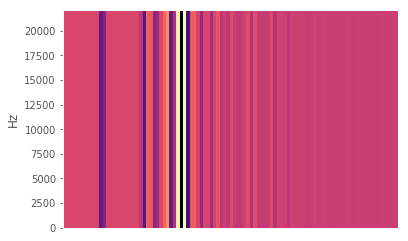

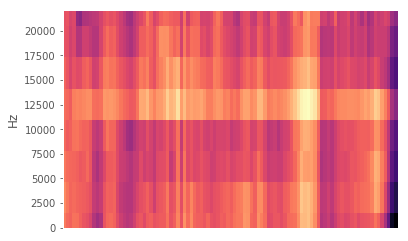

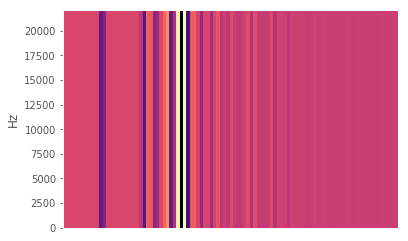

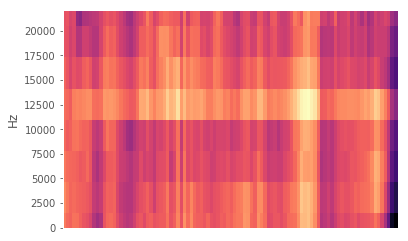

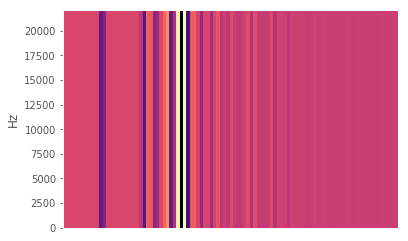

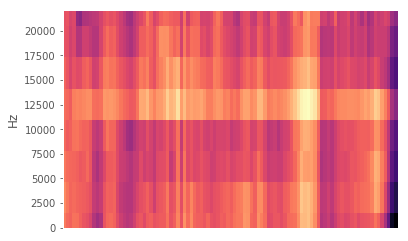

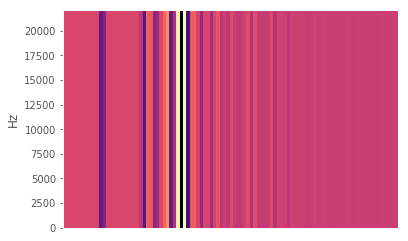

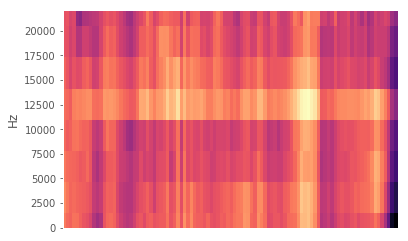

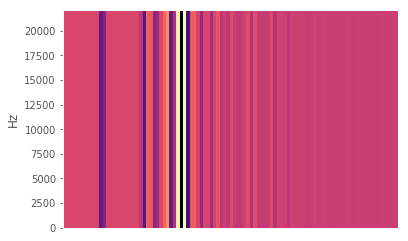

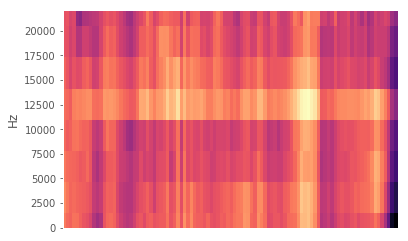

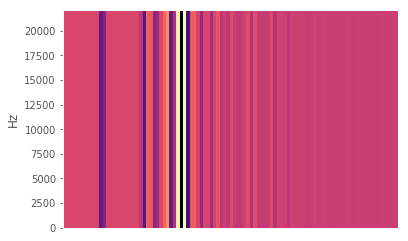

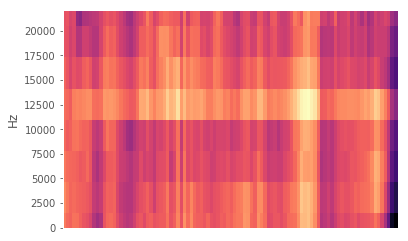

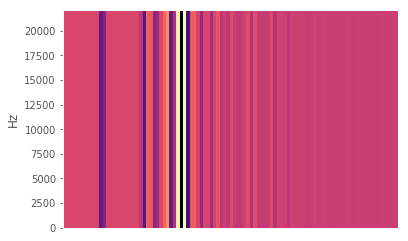

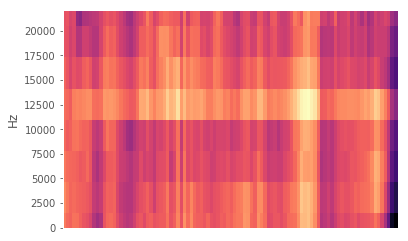

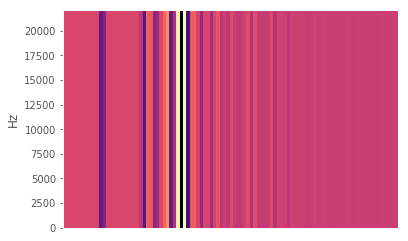

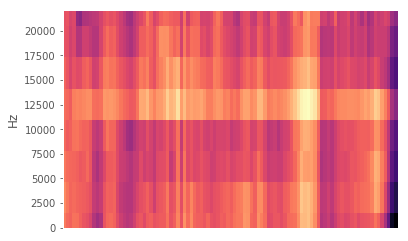

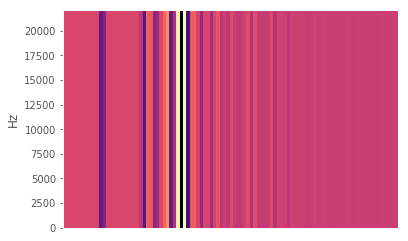

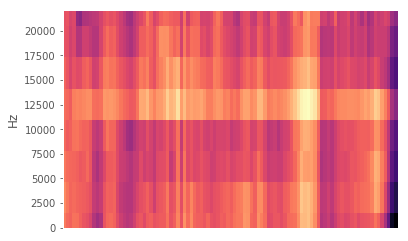

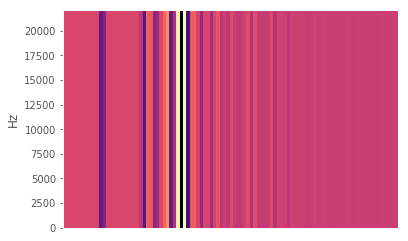

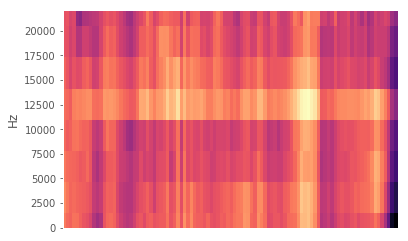

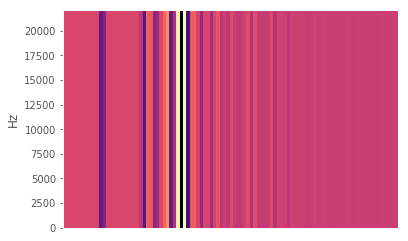

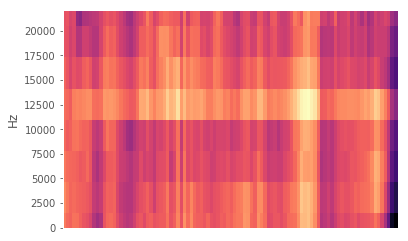

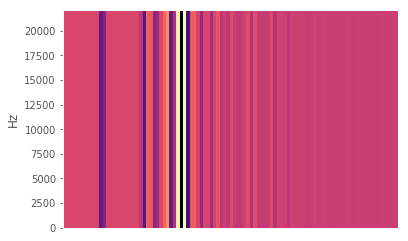

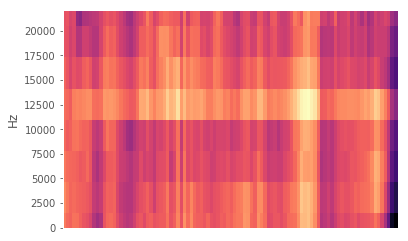

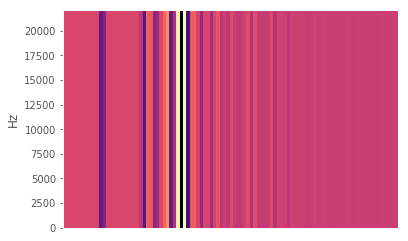

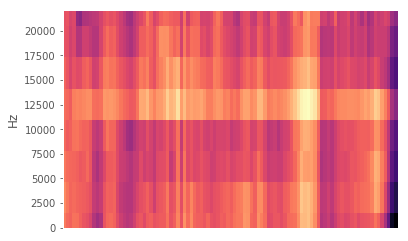

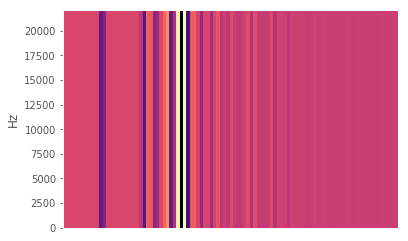

In [39]:
a = auto.predict(file_frames)
for i in range(0, 20):
    display.specshow(a[i], y_axis='linear', sr=SR)
    plt.show()
    display.specshow(file_frames[i], y_axis='linear', sr=SR)
    plt.show()